In [1]:
#import all libraries necessary for the project work
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

In [3]:
#the given information
# share is the call option asset and firm is the counter party asset

#Market information
r = 0.08

#Share specific information
sigma = 0.3
S0 = 100

#call Option specific information
T = 1
K = 100

#firm specific information
V0 = 175 #based on being martingale
sigma_firm = 0.25
debt = 175
recovery_rate = 0.25
correlation = 0.2

#setting seeds.
np.random.seed(0)

def price_path(S0, r, sigma, Z, dT):#Applies to firm and stock
    """Generates asset price given some random normal values, Z"""
    return S0*np.exp(np.cumsum((r-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z))


In [4]:
#monthly simulations for the lifetime of the option
import numpy as np
time = np.linspace(0,1,13)
#setting of monthly time interval
#dT = 1/12 
stock_price_path = [None]*len(time)
firm_price_path = [None]*len(time)
print (time)
#Monte Carlo estimation.
#the code generates 50000 standard normal variables as sample size

for t in range(len(time)):
    dT = time[t]
    corr_mat = np.array([[1,correlation],[correlation,1]])
    norm_mat = norm.rvs(size = np.array([2,50*1000]))
    corr_norm = np.matmul(np.linalg.cholesky(corr_mat),norm_mat)
    stock_price_path = price_path(S0,r,sigma,corr_norm[0,],dT)
    firm_price_path = price_path(V0,r,sigma_firm,corr_norm[1,],dT) 

[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.        ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply


In [5]:
#monthly simulations for the share and counterparty values for the lifetime of the option

time = np.linspace(0,1,13)
stock_price_path = [None]*len(time)
firm_price_path = [None]*len(time)

#Monte Carlo estimation.
#the code generates 1000 standard normal variables as sample size

for t in range(len(time)):
    dT = time[t]
    corr_mat = np.array([[1,correlation],[correlation,1]])
    norm_mat = norm.rvs(size = np.array([2,5*10]))
    corr_norm = np.matmul(np.linalg.cholesky(corr_mat),norm_mat)
    stock_price_path[t-1] = round(np.mean(price_path(S0,r,sigma,corr_norm[0,],dT)),2)
    firm_price_path[t-1] = round(np.mean(price_path(V0,r,sigma_firm,corr_norm[1,],dT)),2)
print(dT,stock_price_path,firm_price_path)

1.0 [143.87, 215.91, 166.72, 149.82, 477.78, 620.48, 199.31, 348.8, 237.69, 604.34, 134.69, 88.75, 100.0] [164.05, 155.77, 126.28, 483.05, 382.82, 152.89, 1072.81, 7225.48, 447.81, 656.17, 486.01, 522.22, 175.0]


In [6]:
k = 100
#re-setting seeds
np.random.seed(0)

#terminal price valuation for both stock and firm
def terminal_value(S0, r,sigma,Z,T):# for both firm and stock
    """Generates the terminal share price given some random normal values, Z"""
    return S0*np.exp((r-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

# put valuations
def call_payoff(S_T,K):
    """Function for evaluating the call price in Monte Carlo Estimation"""
    return np.maximum(S_T-K,0)

#The call_payoff for a call option at terminal time.

mterm_stock_val = [None]*50
mterm_firm_val = [None]*50
mcall_rf_val = [None]*50
cva_estimates = [None]*50
cva_std = [None]*50
call_cr_val = [None]*50


#Monte Carlo estimation.
#the code generates 50000 standard normal variables

for i in range(1,51):
    norm_mat1 = norm.rvs(size = np.array([2,i*1000]))
    corr_norm1 = np.matmul(np.linalg.cholesky(corr_mat),norm_mat1)
    
    term_stock_val = terminal_value(S0,r,sigma,corr_norm1[0,],T)
    #creating array of terminal stock and firm values
    term_firm_val = terminal_value(V0,r,sigma_firm,corr_norm1[1,],T)
    call_df_val = call_payoff(term_stock_val,k)
    #creating arrays of call values for the terminal stock values
    mterm_stock_val[i-1] = np.mean(term_stock_val)
    mterm_firm_val[i-1] = np.mean(term_firm_val)
    mcall_rf_val[i-1] = np.mean(call_df_val)
    #creating an array for risk free call values
    amount_lost = np.exp(-r*T)*(1-recovery_rate)*(term_firm_val<debt)*call_df_val
    cva_estimates = np.mean(amount_lost)
    cva_std = np.std(amount_lost)/np.sqrt(i*1000)
    call_cr_val[i-1] = np.mean(call_df_val)-np.mean(amount_lost)

In [7]:
#calculating the default probability
d_1 = (np.log(V0/debt)+(r + sigma_firm**2/2)*(T))/(sigma_firm*np.sqrt(T))
d_2 = d_1 - sigma_firm*np.sqrt(T)
default_prob = round(norm.cdf(-d_2),2)

#Determining the analytical value for call option
d_1_stock = (np.log(S0/K)+(r + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)
analytic_callprice = round(-K*np.exp(-r*(T))*norm.cdf(d_2_stock)+S0*norm.cdf(d_1_stock),2)


cor_0_cvs = round((1-recovery_rate)*default_prob*analytic_callprice,2)
anal_callprice_df = round((analytic_callprice - cor_0_cvs),2)
print ("analytical call price=", analytic_callprice,"uncorrelated CVS=", cor_0_cvs,"default free call price=",anal_callprice_df)

analytical call price= 15.71 uncorrelated CVS= 4.95 default free call price= 10.76


Text(0, 0.5, 'Value')

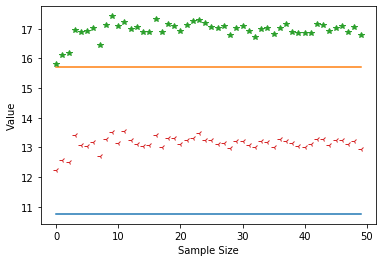

In [8]:
# the plots
plt.plot([anal_callprice_df]*50)
plt.plot([analytic_callprice]*50)
plt.plot(mcall_rf_val,'*')
plt.plot(call_cr_val,'3')
plt.xlabel("Sample Size")
plt.ylabel("Value")  